In [1]:
import os
import sys
import cv2
import time
import mmcv
import torch
import random
import pathlib
import logging
import albumentations
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models.segformer import Segformer

from utils.transformations import re_normalize
from utils.modelsummary import get_model_summary
from utils.runners import train, validate, testval
from utils.label_utils import get_labels
from utils.data_utils import label_mapping, SegmentationDataset, display
from utils.train_utils import AverageMeter, CrossEntropy, get_confusion_matrix, create_logger
from utils.transformations import (ComposeDouble, FunctionWrapperDouble, normalize, re_normalize,
                                   random_crop, random_resize, random_brightness, AlbuSeg2d, scale_aug)




labels = get_labels()
id2label =      { label.id      : label for label in labels }
trainid2label = { label.trainId : label for label in labels }

def cityscapes_label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for key, val in trainid2label.items():
        indices = mask == key
        mask_rgb[indices.squeeze()] = val.color 
    return mask_rgb

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
config = {
    'cityscapes_dir': 'data/cityscapes',
    'trainval_input_pattern': '*_leftImg8bit.png',
    'trainval_annot_pattern': '*_gtFine_labelIds.png',
    'trainval_image_dir': 'leftImg8bit',
    'trainval_label_dir': 'gtFine',
    'pretrained': 'weights/mit_b5.pth',
    
    'DATASET': 'cityscapes',
    'MODEL_NAME': 'segformer',
    'OUTPUT_DIR': 'outputs',
    'LOG_DIR': 'logs',
    
    'CROP_SIZE': (1024, 1024),
    'BASE_SIZE': (1024, 2048),
    'DATASET_MEAN': [0.485, 0.456, 0.406],
    'DATASET_STD': [0.229, 0.224, 0.225],
    'EPOCHS': 400,
    'BATCH_SIZE': 8, 
    'NUM_CLASSES': 19,
    'IGNORE_LABEL': 255,
    'NUM_OUTPUTS': 1,
    'BASE_LR': 0.00006,
    'END_LR': 1e-5
}

In [3]:
transforms_training = ComposeDouble([
    FunctionWrapperDouble(random_resize, scale_factor=16, base_size=config['BASE_SIZE'][1], both=True),
    FunctionWrapperDouble(random_crop, crop_size=config['CROP_SIZE'], ignore_label=config['IGNORE_LABEL'], both=True),
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(label_mapping, label_map=id2label, input=False, target=True),
    FunctionWrapperDouble(random_brightness, input=True, target=False),
    FunctionWrapperDouble(normalize, mean=config['DATASET_MEAN'], std=config['DATASET_STD'], 
                          input=True, target=False),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
])


transforms_validation = ComposeDouble([
    FunctionWrapperDouble(random_crop, crop_size=config['CROP_SIZE'], ignore_label=config['IGNORE_LABEL'], both=True),
    FunctionWrapperDouble(label_mapping, label_map=id2label, input=False, target=True),
    FunctionWrapperDouble(normalize, mean=config['DATASET_MEAN'], std=config['DATASET_STD'], input=True, target=False),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
])

In [10]:
train_dataset = SegmentationDataset(config = config, split = "train", transform = transforms_training)
valid_dataset = SegmentationDataset(config = config, split = "val", transform = transforms_validation)

train_dataloader = DataLoader(dataset = train_dataset, batch_size = config['BATCH_SIZE'], shuffle = True)
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = config['BATCH_SIZE'], shuffle = True)

x, y, _, names = next(iter(train_dataloader))
xv, yv, _, vnames = next(iter(valid_dataloader))

x_min, x_max = x.min(), x.max()
print('x.shape: {}, y.shape'.format(x.numpy().shape, y.numpy().shape))
print('x_val.shape: {}, y_val.shape'.format(xv.numpy().shape, yv.numpy().shape))

0.8 819 1638
--> pad (102,103,0,0)
1.1 1127 2253
0.6 615 1229
--> pad (204,205,0,0)
1.6 1639 3277
1.1 1127 2253
2.0 2048 4096
1.8 1843 3686
1.0 1024 2048
x.shape: (8, 3, 1024, 1024), y.shape
x_val.shape: (8, 3, 1024, 1024), y_val.shape


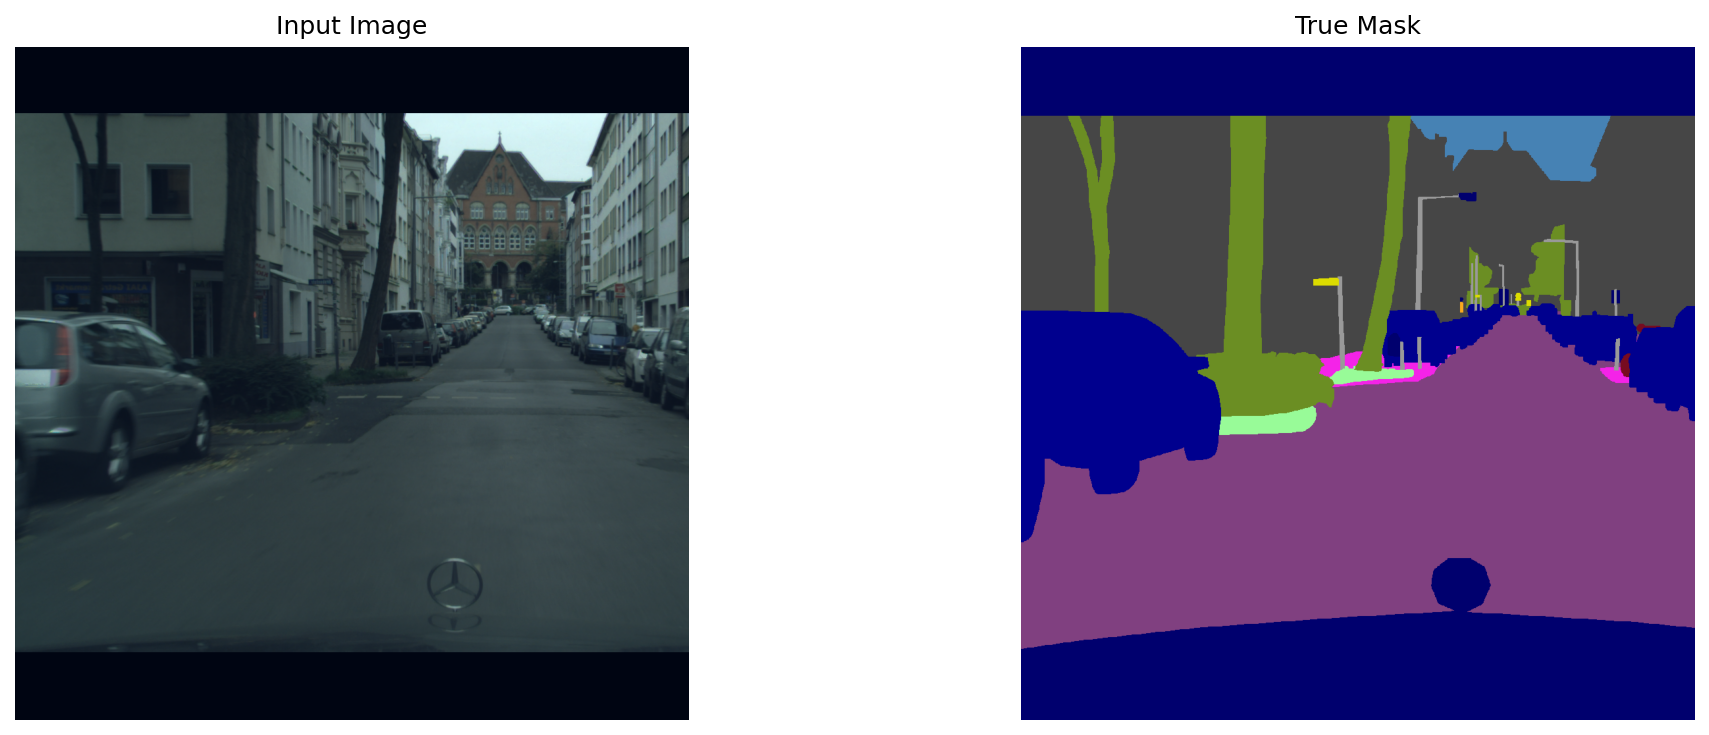

In [11]:
idx = 0
display([re_normalize(x[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(y[idx])])
# display([re_normalize(xv[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(yv[idx])])